# <center>Transer Learning</center>



<div style="text-align: right">60150603 경제학과 박찬혁 </div>


-----------------
## google drive연동

In [64]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [65]:
cd /content/gdrive/My Drive/Colab Notebooks/mju_dnn/mju_DL_project

/content/gdrive/My Drive/Colab Notebooks/mju_dnn/mju_DL_project


In [0]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import pywt
import math
import warnings 
from statsmodels.robust import mad
import keras
warnings.filterwarnings('ignore')


# 사전 학습된 모델 불러오기 

In [0]:
base_model = keras.models.load_model('base_model.h5')
model_on_base = keras.models.Sequential(base_model.layers[:-2]) #출력층 제외 
model_on_base.add(keras.layers.LSTM(100, activation='relu', input_shape = (5, 12),return_sequences=False))
model_on_base.add(keras.layers.Dense(1))

# 사전 학습된 모델과 LSTM 한 층 및 출력층(Dense) 연결 

In [363]:
model_on_base.compile(optimizer = keras.optimizers.adam(lr = 0.001), loss = 'mape')
model_on_base.name = "Transfer_Learning"
for layer in model_on_base.layers[:-2]:
    layer.trainable = False
    layer.name = 'BASE'
print(model_on_base.summary())

Model: "Transfer_Learning"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
BASE (LSTM)                  (None, 5, 100)            45200     
_________________________________________________________________
BASE (LSTM)                  (None, 5, 100)            80400     
_________________________________________________________________
BASE (LSTM)                  (None, 5, 100)            80400     
_________________________________________________________________
BASE (LSTM)                  (None, 5, 100)            80400     
_________________________________________________________________
lstm_41 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 101       
Total params: 447,301
Trainable params: 160,901
Non-trainable params: 286,400
_____________________________________

# 개별 종목 데이터 불러오기 

In [0]:
samsung = pd.read_csv('SAMSUNG.csv')
skhynix = pd.read_csv('SKhynix.csv')
sambio  = pd.read_csv("SAMBI.csv")
naver   = pd.read_csv("NAVER.csv")
celltrion = pd.read_csv("CELLTRION.csv") 

# 주가 객체 생성 

In [0]:
def temp(x,look_back) :
    output_x = []
    for i in range(len(x) - look_back+ 1):
        t = []
        for j in range(look_back) :
            t.append(x[[(i+j)],:])
        output_x.append(t) 
    return output_x

class stock : 
    def __init__(self, data, name,model) :
        self.name = name
        self.data = data.drop('Date',axis = 1) 
        self.close = self.data['Close']
        self.features = self.data.drop("Close", axis = 1).values
        self.timesteps = 5
        self.n_features = 12
        self.model = model 

    # wavelet transform
    def wt(self):
        levels =  int(math.log(len(self.close.values), 2)) #  시계열 길이에 따른 레벨 
        coef = pywt.wavedec(data = self.close.values, wavelet= 'haar', level = levels) #wavelet decompostion using "haar" wavelet
        sigma = 1.4826 * mad(abs(coef[-1]))
        threshold = sigma * np.sqrt(2 * np.log(len(self.close.values))) # universal threshold
        for level in range(1, len(coef)) :
            thresholding = pywt.threshold(data = coef[level], value = threshold, mode = 'soft')
            coef[level] = thresholding
        recon = pywt.waverec(coef, wavelet = 'haar')
        return recon 

    def wt_plot(self): 
        self.wt = self.wt()
        fig = plt.figure(figsize = (20, 5))
        plt.plot(self.close.values, alpha = 0.7, c = 'blue', label = 'original')
        plt.plot(self.wt, c = 'red', label = 'denoised')
        plt.legend(loc = 'upper left')
        plt.grid()
        plt.show()
    

    def preprocessing_fof_LSTM(self) :        
        self.x=  temp(self.features,look_back = self.timesteps)
        self.x = np.array(self.x)
        self.x = self.x.reshape(self.x.shape[0], self.timesteps, self.n_features)
        self.y = self.wt() # wavelet transform 
        self.close = self.close[self.timesteps - 1 : ]
        self.y = self.y[self.timesteps - 1 : len(self.y)-1]
        
        # train _test split 
        self.x_train = self.x[0:300]
        self.y_train = self.y[0:300]
        self.x_test  = self.x[300:]
        self.y_test  = self.y[300:]
        self.actual_y_train = self.close[0:300].values
        self.actual_y_test  = self.close[300:].values


    def mape(self, pred, actual):
        abs_diff = np.abs(pred - actual)
        mape = abs_diff / actual 
        return np.round(np.mean(mape)*100,3) 

    def train(self, epochs, verbose = 0):

        self.preprocessing_fof_LSTM()
        self.history = self.model.fit(self.x_train, self.y_train, epochs = epochs, verbose = verbose, validation_data = (self.x_test, self.y_test))
            
        self.pred_train = self.model.predict(self.x_train)
        self.pred_val   = self.model.predict(self.x_test)

        print("{} train set  MAPE : {:.3f} %".format(self.name, np.min(self.history.history['loss'])))
        print("{} test  set  MAPE : {:.3f} %".format(self.name, np.min(self.history.history['val_loss'])))
        print('==============================')


Samsung train set  MAPE : 0.738 %
Samsung test  set  MAPE : 2.283 %


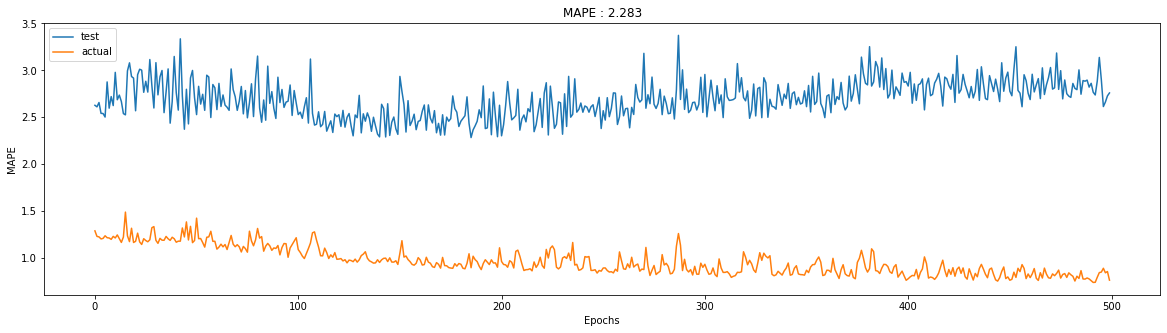

In [305]:
SAMSUNG = stock(data = samsung, name = 'Samsung', model =model_on_base)
SAMSUNG.train(epochs=500)
plt.figure(figsize = (20,5))
plt.plot(SAMSUNG.history.history['val_loss'],label = 'test')
plt.plot(SAMSUNG.history.history['loss'], label ='actual')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.title("MAPE : {:.3f}".format(np.min(SAMSUNG.history.history['val_loss'])))
plt.legend(loc = 'upper left')
plt.show()

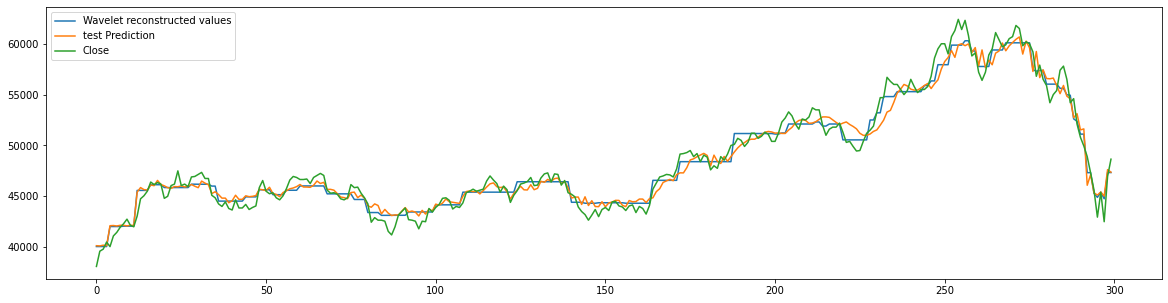

In [306]:
plt.figure(figsize = (20,5))
plt.plot(SAMSUNG.y[:300], label = 'Wavelet reconstructed values')
plt.plot(SAMSUNG.model.predict(SAMSUNG.x_train), label = 'test Prediction')
plt.plot(SAMSUNG.close.values[:300], label = 'Close')
plt.legend(loc = 'upper left')

SAMSUNG_ElEC train set  MAPE : 0.885 %
SAMSUNG_ElEC test  set  MAPE : 1.533 %
SKhynix train set  MAPE : 1.257 %
SKhynix test  set  MAPE : 1.558 %
SAMSUNG_BIO train set  MAPE : 1.563 %
SAMSUNG_BIO test  set  MAPE : 5.755 %
NAVER train set  MAPE : 1.053 %
NAVER test  set  MAPE : 4.358 %
CELLTRION train set  MAPE : 1.271 %
CELLTRION test  set  MAPE : 2.223 %


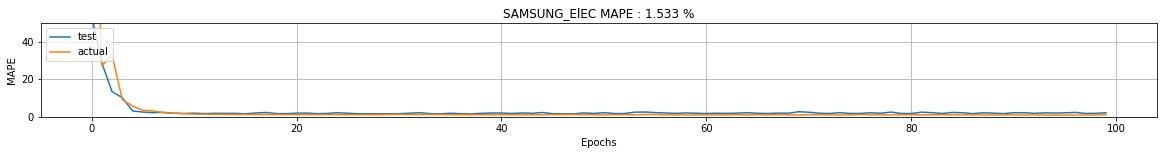

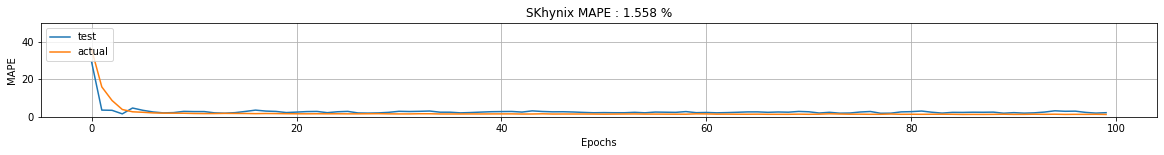

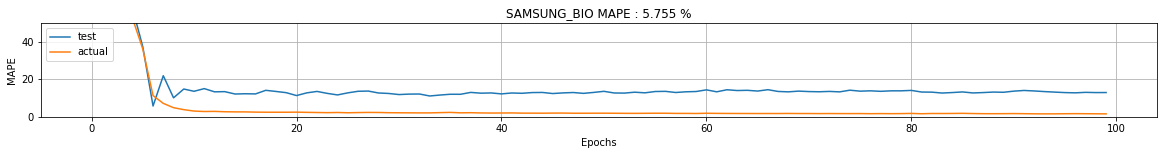

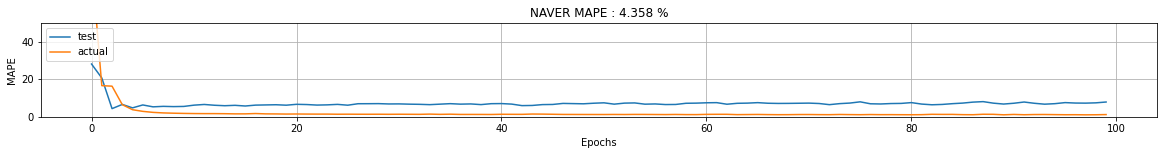

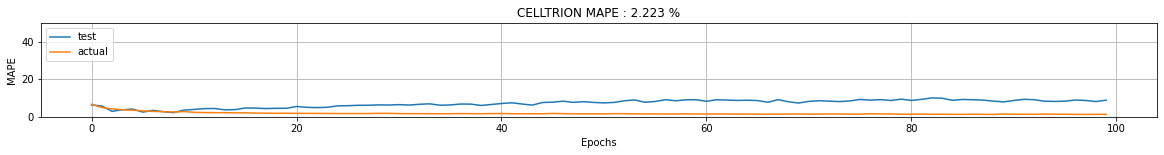

In [308]:
stock_dic = {"SAMSUNG_ElEC":samsung,"SKhynix" :skhynix,"SAMSUNG_BIO":sambio,"NAVER":naver,"CELLTRION":celltrion}

index = 1

for key in stock_dic :
    
    price = stock(data = stock_dic[key], name = key,model_on_base)
    price.train(epochs=100)
    plt.figure(figsize = (20,10))
    plt.subplot(5, 1,index)
    index+=1 
    plt.plot(price.history.history['val_loss'],label = 'test')
    plt.plot(price.history.history['loss'], label ='actual')
    plt.ylim(0,50)
    plt.xlabel('Epochs')
    plt.ylabel('MAPE')
    plt.title("{} MAPE : {:.3f} %".format(key,np.min(price.history.history['val_loss'])))
    plt.legend(loc = 'upper left')
    plt.grid()
plt.show()
    

In [337]:

model_part = keras.models.Sequential()

model_part.add(keras.layers.LSTM(100, activation='relu', input_shape = (5,12),return_sequences=True))
model_part.add(keras.layers.LSTM(100, activation='relu',return_sequences=True))
model_part.add(keras.layers.LSTM(100, activation='relu',return_sequences=True))
model_part.add(keras.layers.LSTM(100, activation='relu', return_sequences=True))
model_part.add(keras.layers.LSTM(100, activation='relu', return_sequences=False))
model_part.add(keras.layers.Dense(1))
model_part.compile(optimizer = keras.optimizers.adam(lr = 0.01), loss = 'mape')

print(model_part.summary())

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 5, 100)            45200     
_________________________________________________________________
lstm_37 (LSTM)               (None, 5, 100)            80400     
_________________________________________________________________
lstm_38 (LSTM)               (None, 5, 100)            80400     
_________________________________________________________________
lstm_39 (LSTM)               (None, 5, 100)            80400     
_________________________________________________________________
lstm_40 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 101       
Total params: 366,901
Trainable params: 366,901
Non-trainable params: 0
_______________________________________________

SAMSUNG_ElEC train set  MAPE : 2.059 %
SAMSUNG_ElEC test  set  MAPE : 1.488 %
SKhynix train set  MAPE : 2.238 %
SKhynix test  set  MAPE : 1.172 %
SAMSUNG_BIO train set  MAPE : 2.373 %
SAMSUNG_BIO test  set  MAPE : 3.266 %
NAVER train set  MAPE : 1.336 %
NAVER test  set  MAPE : 4.206 %
CELLTRION train set  MAPE : 1.810 %
CELLTRION test  set  MAPE : 2.127 %


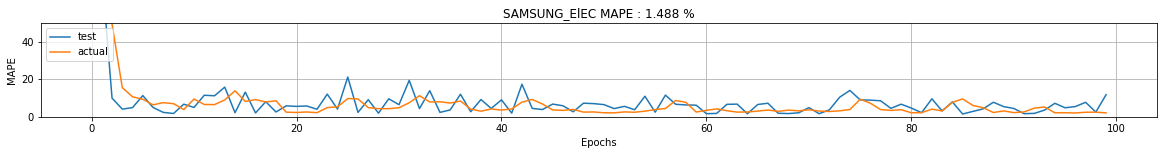

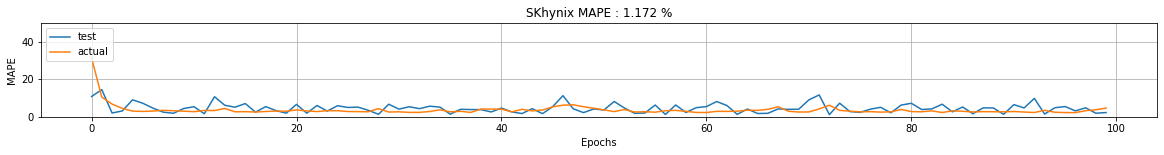

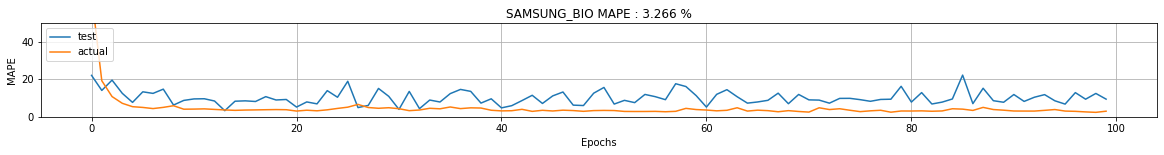

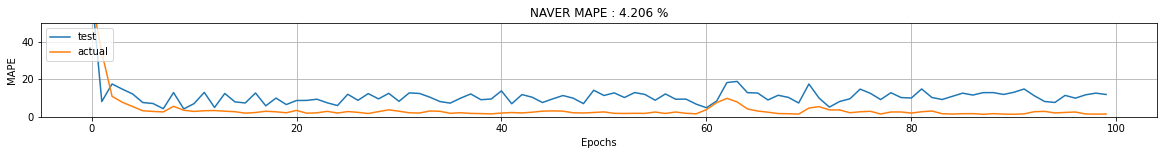

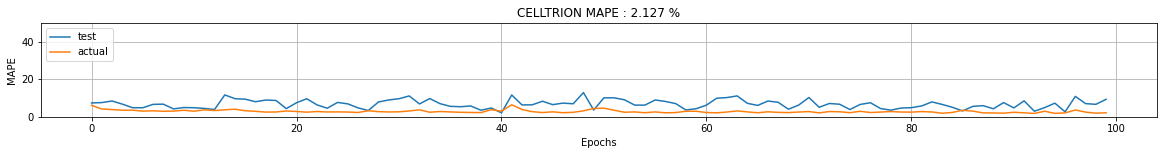

In [322]:
index = 1

for key in stock_dic :
    
    price = stock(data = stock_dic[key], name = key, model = model_part)
    price.train(epochs=100)
    plt.figure(figsize = (20,10))
    plt.subplot(5, 1,index)
    index+=1 
    plt.plot(price.history.history['val_loss'],label = 'test')
    plt.plot(price.history.history['loss'], label ='actual')
    plt.ylim(0,50)
    plt.xlabel('Epochs')
    plt.ylabel('MAPE')
    plt.title("{} MAPE : {:.3f} %".format(key,np.min(price.history.history['val_loss'])))
    plt.legend(loc = 'upper left')
    plt.grid()
plt.show()

In [0]:
from keras.models import load_model
model_on_base.save('transfer_learning.h5')

In [362]:
import scipy 

for key in stock_dic :
    
    tl = stock(data = stock_dic[key], name = key, model = model_on_base)
    sl = stock(data = stock_dic[key], name = key, model = model_part)
    tl.train(epochs = 100 )
    sl.train(epochs = 100 )
    pred_tl = tl.model.predict(tl.x_test)
    pred_sl = sl.model.predict(sl.x_test)
    ttest = scipy.stats.ttest_rel(pred_tl, pred_sl)
    print("{} T-test p-value : {:.2f}".format(key, ttest[1][0]))


SAMSUNG_ElEC train set  MAPE : 1.345 %
SAMSUNG_ElEC test  set  MAPE : 2.284 %
SAMSUNG_ElEC train set  MAPE : 1.276 %
SAMSUNG_ElEC test  set  MAPE : 1.989 %
SAMSUNG_ElEC T-test p-value : 0.00
SKhynix train set  MAPE : 1.808 %
SKhynix test  set  MAPE : 2.525 %
SKhynix train set  MAPE : 1.288 %
SKhynix test  set  MAPE : 2.867 %
SKhynix T-test p-value : 0.00
SAMSUNG_BIO train set  MAPE : 2.027 %
SAMSUNG_BIO test  set  MAPE : 6.892 %
SAMSUNG_BIO train set  MAPE : 1.383 %
SAMSUNG_BIO test  set  MAPE : 3.938 %
SAMSUNG_BIO T-test p-value : 0.26
NAVER train set  MAPE : 1.382 %
NAVER test  set  MAPE : 4.430 %
NAVER train set  MAPE : 1.054 %
NAVER test  set  MAPE : 2.673 %
NAVER T-test p-value : 0.00
CELLTRION train set  MAPE : 1.307 %
CELLTRION test  set  MAPE : 2.946 %
CELLTRION train set  MAPE : 1.166 %
CELLTRION test  set  MAPE : 2.346 %
CELLTRION T-test p-value : 0.05
